In [15]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [16]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [17]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
tdesignregion   = 1
monitor_position = 2 * 1 / fcen
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 1

Sx = tpml+width_bot_ag+tpml
Sy = tag_bot+tag_side+tdesignregion+monitor_position+monitor_blank+tpml

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + 2*1/fcen
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, center_y_design, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [18]:
cell_size = mp.Vector3(Sx, Sy)
geometry = [
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    mp.Block(
        material=design_variables,
        size=mp.Vector3(design_region_width, design_region_height, 0),
        center=mp.Vector3(0, center_y_design, 0)
    ),

    ######### Side metal ########## 
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]

In [90]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )


sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

In [91]:
offset = 0.01
flux_size = 0.02
mn_size = 2

monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(mn_size,0,0)

#### input source의 flux ####
input_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

-----------
Initializing structure...
time for choose_chunkdivision = 4.60148e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.96 x 0 with resolution 50
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0717959 s
time for set_conductivity = 0.00231194 

field decay(t = 210.07): 0.014463494526639488 / 27.717833220969734 = 0.0005218118750962551
run 0 finished at t = 210.07 (21007 timesteps)
     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

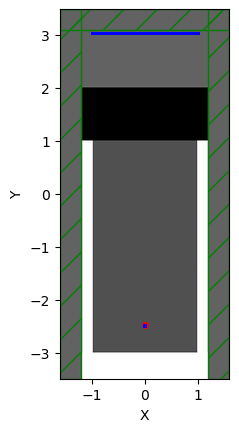

In [92]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(30, mp.Ez, sources.center, 1e-3))

sim.plot2D()


     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)


          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

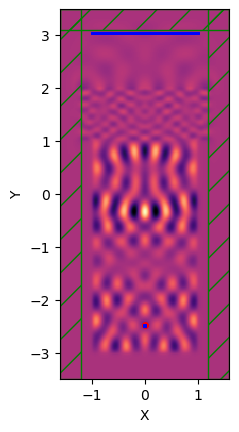

In [124]:
sim.plot2D(fields = mp.Ez,
           field_parameters={
        'cmap': 'magma',    # magma 컬러맵 지정
        'alpha': 1,       # 필드 투명도 (0.0~1.0)
        'interpolation': 'none'
    }
)

     block, center = (0,-3.23455,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.984545,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.51545,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.984545,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


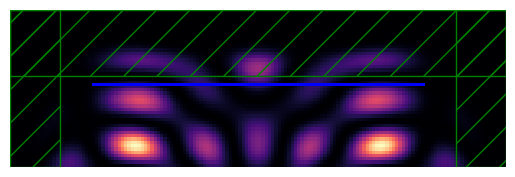

In [136]:
sim.plot2D(
    fields=mp.Ez,
    output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(3, 1)),
    field_parameters={
        'post_process': lambda x: np.abs(np.real(x))**2,  # 복소수 필드 x → intensity |x|^2
        'cmap': 'magma',                         # 원하시는 colormap
        'alpha': 1,                            # 투명도
        'interpolation': 'none'
    },
    eps_parameters={'cmap':'magma','alpha':1}
)
plt.axis(False)
plt.show()

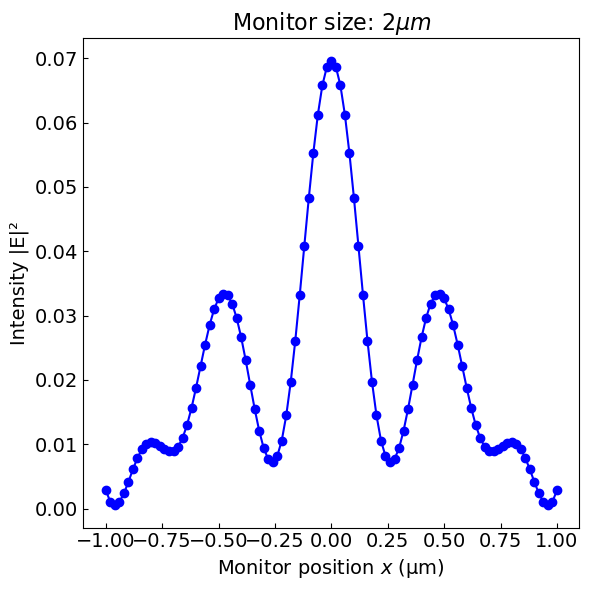

In [156]:
external_field_array = sim.get_dft_array(dft_fields, mp.Ez, 0)

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')

plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

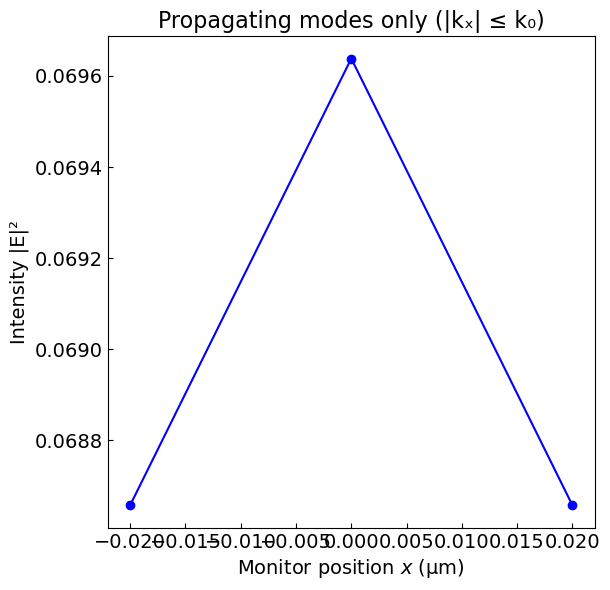

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ——— 1) 시뮬레이션 데이터 & 기본 변수 ———
external_field_array = sim.get_dft_array(dft_fields, mp.Ez, 0)  # E(x) at the monitor
I  = np.abs(external_field_array)**2
N  = len(external_field_array)
W  = mn_size                            # monitor 폭 (µm)
x  = np.linspace(-W/2, W/2, N)         # monitor 상의 위치 (µm)
dx = x[1] - x[0]                        # 샘플 간격 (µm)
lambda_ = 1/fcen                        # 파장 (µm)
k0 = 2 * np.pi / lambda_                # 진공 파수 (rad/µm)

# ——— 2) kₓ 스펙트럼 계산 ———
E_k     = np.fft.fftshift(np.fft.fft(external_field_array)) / N
kx_cyc  = np.fft.fftshift(np.fft.fftfreq(N, d=dx))    # cycle/µm
kx      = 2 * np.pi * kx_cyc                         # rad/µm

# ——— 3) mask: 전파 모드만 (|kₓ| ≤ k₀) ———
mask    = np.abs(kx) <= k0

# mask 적용: 위치 x, 강도 I 만 남김
x_prop  = x[mask]
I_prop  = I[mask]

# ——— 4) 모니터 위치(x) 축으로 플롯 ———
plt.figure(figsize=(6,6))
plt.plot(x_prop, I_prop, 'bo-')
plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
plt.title('Propagating modes only (|kₓ| ≤ k₀)', fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()


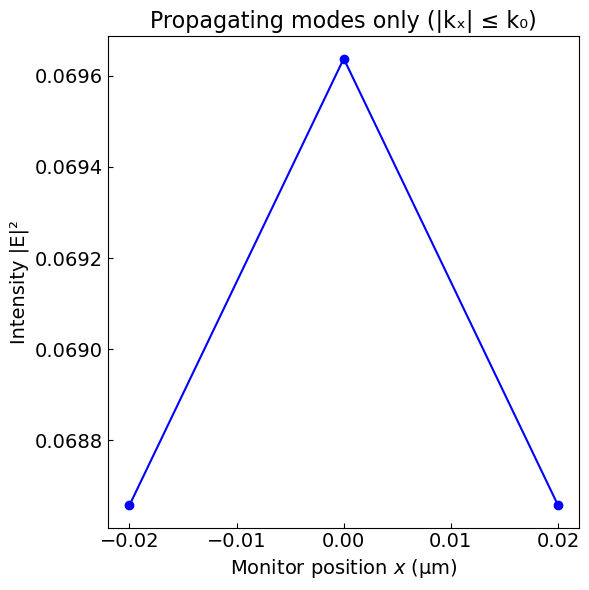

In [186]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# ——— 1) 시뮬레이션 데이터 & 기본 변수 ———
external_field_array = sim.get_dft_array(dft_fields, mp.Ez, 0)
I  = np.abs(external_field_array)**2
N  = len(external_field_array)
W  = mn_size
x  = np.linspace(-W/2, W/2, N)
dx = x[1] - x[0]
lambda_ = 1/fcen
k0 = 2 * np.pi / lambda_

# ——— 2) kₓ 스펙트럼 계산 ———
E_k    = np.fft.fftshift(np.fft.fft(external_field_array)) / N
kx_cyc = np.fft.fftshift(np.fft.fftfreq(N, d=dx))
kx     = 2 * np.pi * kx_cyc

# ——— 3) mask: 전파 모드만 (|kₓ| ≤ k₀) ———
mask    = np.abs(kx) <= k0
x_prop  = x[mask]
I_prop  = I[mask]

# ——— 4) 플롯 ———
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x_prop, I_prop, 'bo-')

# x축 눈금 간격 0.1 µm 로 설정
ax.xaxis.set_major_locator(MultipleLocator(0.01))

ax.set_xlabel('Monitor position $x$ (µm)', fontsize=14)
ax.set_ylabel('Intensity |E|²',       fontsize=14)
ax.set_title('Propagating modes only (|kₓ| ≤ k₀)', fontsize=16)
ax.tick_params(direction='in', labelsize=14)
ax.grid(False)
plt.tight_layout()
plt.show()


In [167]:
# 1) propagating 모드만 남기고 IFFT (이전 코드와 동일)
E_k_prop    = E_k.copy()
E_k_prop[~mask] = 0
E_prop      = np.fft.ifft(np.fft.ifftshift(E_k_prop)) * N

# 2) real-space intensity & flux 적분
I_prop      = np.abs(E_prop)**2
output_flux = np.trapz(I_prop, x)
output_flux

0.01979782560676902

In [169]:
def compute_fwhm(x, I):
    import numpy as np

    half_max = np.max(I) / 2
    inds     = np.where(I >= half_max)[0]
    if len(inds) < 2:
        return None  # 반치점 교차가 없으면

    left, right = inds[0], inds[-1]
    # 보간
    x1 = x[left-1] + (half_max - I[left-1]) * (x[left] - x[left-1]) / (I[left] - I[left-1])
    x2 = x[right] + (half_max - I[right]) * (x[right+1] - x[right]) / (I[right+1] - I[right])
    return x2 - x1

input = np.array(mp.get_fluxes(input_flux))[0]
# output = np.array(mp.get_fluxes(out_flux))[0]

# 퍼센트로 표현한 EQE
eqe = output_flux/input*100

# 사용 예
fwhm_value = compute_fwhm(x, I)
print("FWHM:", fwhm_value)
print("Input flux :", input)
print("Output flux :", output_flux)
print("EQE :", eqe)

FWHM: 0.27179804953789655
Input flux : 0.08402569327486548
Output flux : 0.01979782560676902
EQE : 23.561633156665813


In [151]:
def compute_fwhm(x, I):
    import numpy as np

    half_max = np.max(I) / 2
    inds     = np.where(I >= half_max)[0]
    if len(inds) < 2:
        return None  # 반치점 교차가 없으면

    left, right = inds[0], inds[-1]
    # 보간
    x1 = x[left-1] + (half_max - I[left-1]) * (x[left] - x[left-1]) / (I[left] - I[left-1])
    x2 = x[right] + (half_max - I[right]) * (x[right+1] - x[right]) / (I[right+1] - I[right])
    return x2 - x1

# output_flux = mp.get_fluxes()

# 사용 예
fwhm_value = compute_fwhm(x, I)
print("FWHM:", fwhm_value)
print("Input flux :", )
print("Output flux :", )


FWHM: 0.27179804953789655
Input flux :
Output flux :
